In [1]:
import glob
import os
import json

import pandas as pd
import numpy as np
import nibabel as nib

import fastai
from fastMONAI.vision_all import *
from monai.networks.nets import UNet
from monai.losses import DiceCELoss

import scipy.ndimage 
from sklearn.model_selection import train_test_split
from skimage.measure import label, regionprops

from useful_functions import *

In [2]:
bids_dir = "bids-new"

In [3]:
session_dirs = []
for json_path in sorted(glob.glob(os.path.join(bids_dir, "sub*", "ses*", "anat", "*echo-01*mag*json"))):
    with open(json_path, 'r') as json_file:
        json_data = json.load(json_file)
        if json_data['ProtocolName'] == "t2starME_qsm_tra_Iso1.4mm_INPHASE_bipolar_RUN_THIS_ONE":
            session_dirs.append(os.sep.join(os.path.split(json_path)[0].split(os.sep)[:-1]))
print(f"{len(session_dirs)} sessions found:")
for session_dir in session_dirs: print(session_dir)

15 sessions found:
bids-new/sub-z0034542/ses-20220715
bids-new/sub-z0186251/ses-20221107
bids-new/sub-z0705200/ses-20230104
bids-new/sub-z0755228/ses-20211108
bids-new/sub-z1167038/ses-20220315
bids-new/sub-z1181657/ses-20220315
bids-new/sub-z1262112/ses-20220314
bids-new/sub-z1472355/ses-20221222
bids-new/sub-z1728751/ses-20220328
bids-new/sub-z1778013/ses-20220715
bids-new/sub-z1818796/ses-20230313
bids-new/sub-z2007565/ses-20220715
bids-new/sub-z2904752/ses-20220826
bids-new/sub-z3171177/ses-20230313
bids-new/sub-z3278008/ses-20211109


In [4]:
qsm_files = [glob.glob(os.path.join(session_dir, "extra_data", "*qsm_echo2-and-echo4.*")) for session_dir in session_dirs]
seg_files = [glob.glob(os.path.join(session_dir, "extra_data", "*segmentation_clean.*")) for session_dir in session_dirs]
ct_files = [glob.glob(os.path.join(session_dir, "extra_data", "*_na_*.nii*")) for session_dir in session_dirs] + \
           [glob.glob(os.path.join(session_dir, "extra_data", "*_Pelvis_*.nii*")) for session_dir in session_dirs]
t2s_files = [glob.glob(os.path.join(session_dir, "extra_data", "*t2starmap.nii*")) for session_dir in session_dirs]
mag_files = [glob.glob(os.path.join(session_dir, "extra_data", "*magnitude_combined.nii*")) for session_dir in session_dirs]

qsm_files = [qsm_file_list[0] for qsm_file_list in qsm_files if len(qsm_file_list)]
seg_files = [seg_file_list[0] for seg_file_list in seg_files if len(seg_file_list)]
ct_files = sorted(list(set([ct_file_list[0] for ct_file_list in ct_files if len(ct_file_list)])))
t2s_files = [t2s_file_list[0] for t2s_file_list in t2s_files if len(t2s_file_list)]
mag_files = [mag_file_list[0] for mag_file_list in mag_files if len(mag_file_list)]

print(f"{len(ct_files)} CT images found.")
print(f"{len(qsm_files)} QSM images found.")
print(f"{len(mag_files)} magnitude images found.")
print(f"{len(t2s_files)} T2* maps found.")
print(f"{len(seg_files)} segmentations found.")

15 CT images found.
15 QSM images found.
12 magnitude images found.
12 T2* maps found.
15 segmentations found.


In [5]:
seg_files

['bids-new/sub-z0034542/ses-20220715/extra_data/sub-z0034542_ses-20220715_run-01_segmentation_clean.nii.gz',
 'bids-new/sub-z0186251/ses-20221107/extra_data/sub-z0186251_ses-20221107_run-01_segmentation_clean.nii.gz',
 'bids-new/sub-z0705200/ses-20230104/extra_data/sub-z0705200_ses-20230104_run-01_segmentation_clean.nii',
 'bids-new/sub-z0755228/ses-20211108/extra_data/sub-z0755228_ses-20211108_run-01_segmentation_clean.nii.gz',
 'bids-new/sub-z1167038/ses-20220315/extra_data/sub-z1167038_ses-20220315_run-01_segmentation_clean.nii.gz',
 'bids-new/sub-z1181657/ses-20220315/extra_data/sub-z1181657_ses-20220315_run-01_segmentation_clean.nii.gz',
 'bids-new/sub-z1262112/ses-20220314/extra_data/sub-z1262112_ses-20220314_run-01_segmentation_clean.nii.gz',
 'bids-new/sub-z1472355/ses-20221222/extra_data/sub-z1472355_ses-20221222_run-01_segmentation_clean.nii',
 'bids-new/sub-z1728751/ses-20220328/extra_data/sub-z1728751_ses-20220328_run-01_segmentation_clean.nii.gz',
 'bids-new/sub-z1778013/s

# Gold marker segmentation with QSM

## Prepare data
### Locate input data

The files are 3D NIfTI images.

In [6]:
# input data
qsm_files = [x for x in sorted(glob.glob("bids/sub-*/ses-*/extra_data/*qsm.nii*")) if '-new' not in x]
seg_files = [x for x in sorted(glob.glob("bids/sub-*/ses-*/extra_data/*segmentation*clean.nii*")) if '-new' not in x]
t2s_files = [x for x in sorted(glob.glob("bids/sub-*/ses-*/extra_data/*t2starmap.nii*")) if '-new' not in x]
mag_files = [x for x in sorted(glob.glob("bids/sub-*/ses-*/extra_data/*magnitude_combined.nii*")) if '-new' not in x]
assert(len(qsm_files) == len(seg_files))
df = pd.DataFrame({ 'qsm_files' : qsm_files, 'seg_files' : seg_files })
df

,qsm_files,seg_files
0,bids/sub-z0034542/ses-20220715/extra_data/sub-z0034542_ses-20220715_run-01_qsm.nii,bids/sub-z0034542/ses-20220715/extra_data/sub-z0034542_ses-20220715_run-01_segmentation_clean.nii.gz
1,bids/sub-z0186251/ses-20221107/extra_data/sub-z0186251_ses-20221107_run-01_qsm.nii,bids/sub-z0186251/ses-20221107/extra_data/sub-z0186251_ses-20221107_run-01_segmentation_clean.nii.gz
2,bids/sub-z0705200/ses-20230104/extra_data/sub-z0705200_ses-20230104_run-01_qsm.nii,bids/sub-z0705200/ses-20230104/extra_data/sub-z0705200_ses-20230104_run-01_segmentation_clean.nii
3,bids/sub-z0755228/ses-20211108/extra_data/sub-z0755228_ses-20211108_run-01_qsm.nii,bids/sub-z0755228/ses-20211108/extra_data/sub-z0755228_ses-20211108_run-01_segmentation_clean.nii.gz
4,bids/sub-z1167038/ses-20220315/extra_data/sub-z1167038_ses-20220315_run-01_qsm.nii,bids/sub-z1167038/ses-20220315/extra_data/sub-z1167038_ses-20220315_run-01_segmentation_clean.nii.gz
5,bids/sub-z1181657/ses-20220315/extra_data/sub-z1181657_ses-20220315_run-01_qsm.nii,bids/sub-z1181657/ses-20220315/extra_data/sub-z1181657_ses-20220315_run-01_segmentation_clean.nii.gz
6,bids/sub-z1262112/ses-20220314/extra_data/sub-z1262112_ses-20220314_run-01_qsm.nii,bids/sub-z1262112/ses-20220314/extra_data/sub-z1262112_ses-20220314_run-01_segmentation_clean.nii.gz
7,bids/sub-z1472355/ses-20221222/extra_data/sub-z1472355_ses-20221222_run-01_qsm.nii,bids/sub-z1472355/ses-20221222/extra_data/sub-z1472355_ses-20221222_run-01_segmentation_clean.nii
8,bids/sub-z1728751/ses-20220328/extra_data/sub-z1728751_ses-20220328_run-01_qsm.nii,bids/sub-z1728751/ses-20220328/extra_data/sub-z1728751_ses-20220328_run-01_segmentation_clean.nii.gz
9,bids/sub-z1778013/ses-20220715/extra_data/sub-z1778013_ses-20220715_run-01_qsm.nii,bids/sub-z1778013/ses-20220715/extra_data/sub-z1778013_ses-20220715_run-01_segmentation_clean.nii.gz


In [7]:
train_df, test_df = train_test_split(df, test_size=2, random_state=42)
print(f"Training samples shape: {train_df.shape}")
print(f"Testing samples shape: {test_df.shape}")

med_dataset = MedDataset(
    img_list=train_df.seg_files.tolist(),
    dtype=MedMask,
    max_workers=12
)

suggested_voxelsize, requires_resampling = med_dataset.suggestion()
largest_imagesize = med_dataset.get_largest_img_size(resample=suggested_voxelsize)
print(f"Suggested voxel size: {suggested_voxelsize}")
print(f"Requires resampling: {requires_resampling}")
print(f"Largest image size: {largest_imagesize}")

Training samples shape: (11, 2)
Testing samples shape: (2, 2)
Suggested voxel size: [1.4, 1.4, 1.4]
Requires resampling: False
Largest image size: [146.0, 160.0, 72.0]


In [8]:
def get_center_slices(mask):
    labeled_mask = label(mask)
    regions = regionprops(labeled_mask)
    center_slices = [[round(coord) for coord in region.centroid] for region in regions]
    return center_slices

class SetVrange(DisplayedTransform):
    def __init__(self, vmin, vmax):
        self.vmin = vmin
        self.vmax = vmax

    def encodes(self, o:MedImage):
        o[o > self.vmax] = 0
        o[o < self.vmin] = 0
        return o
    
def show_images(x, y, figsize=None):
    n_samples = x.shape[0]
    n_masks = y.shape[0]
    assert(n_samples == n_masks)

    if y.shape[1] > 1:
        mask = torch.argmax(y, dim=1).unsqueeze(1).cpu().numpy()
    else:
        mask = y.cpu().numpy()
    qsm = x.cpu().numpy()

    max_sources = 0
    for i in range(n_samples):
        center_slices = get_center_slices(np.array(mask[i][0] != 0, dtype=int))
        num_sources = len(center_slices)
        max_sources = max(num_sources, max_sources)

    img_width = 5
    img_height = 5
    wspace = 0.1
    hspace = 0.1
    fig_width = img_width * max_sources + wspace * (max_sources - 1)
    fig_height = img_height * n_samples + hspace * (n_samples - 1)
    fig, axes = plt.subplots(ncols=max_sources, nrows=n_samples, figsize=(fig_width, fig_height), squeeze=False)
    
    for ax in axes.flat:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_axis_off()
    
    for i in range(n_samples):
        center_slices = get_center_slices(np.array(mask[i][0] != 0, dtype=int))
        num_sources = len(center_slices)

        for j in range(num_sources):
            axes[i,j].imshow(qsm[i][0][center_slices[j][0],:,:], cmap='gray', vmin=-5, vmax=+5, interpolation='nearest') 
            axes[i,j].imshow(mask[i][0][center_slices[j][0],:,:], cmap='Set1', vmin=1, vmax=9, alpha=np.array(mask[i][0][center_slices[j][0],:,:] != 0, dtype=int) * 0.6)

    plt.show()
    plt.close()
    
@typedispatch
def show_batch(x:MedImage, y:MedMask, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    show_images(x, y)
    

Training examples: 9
Validation examples: 2


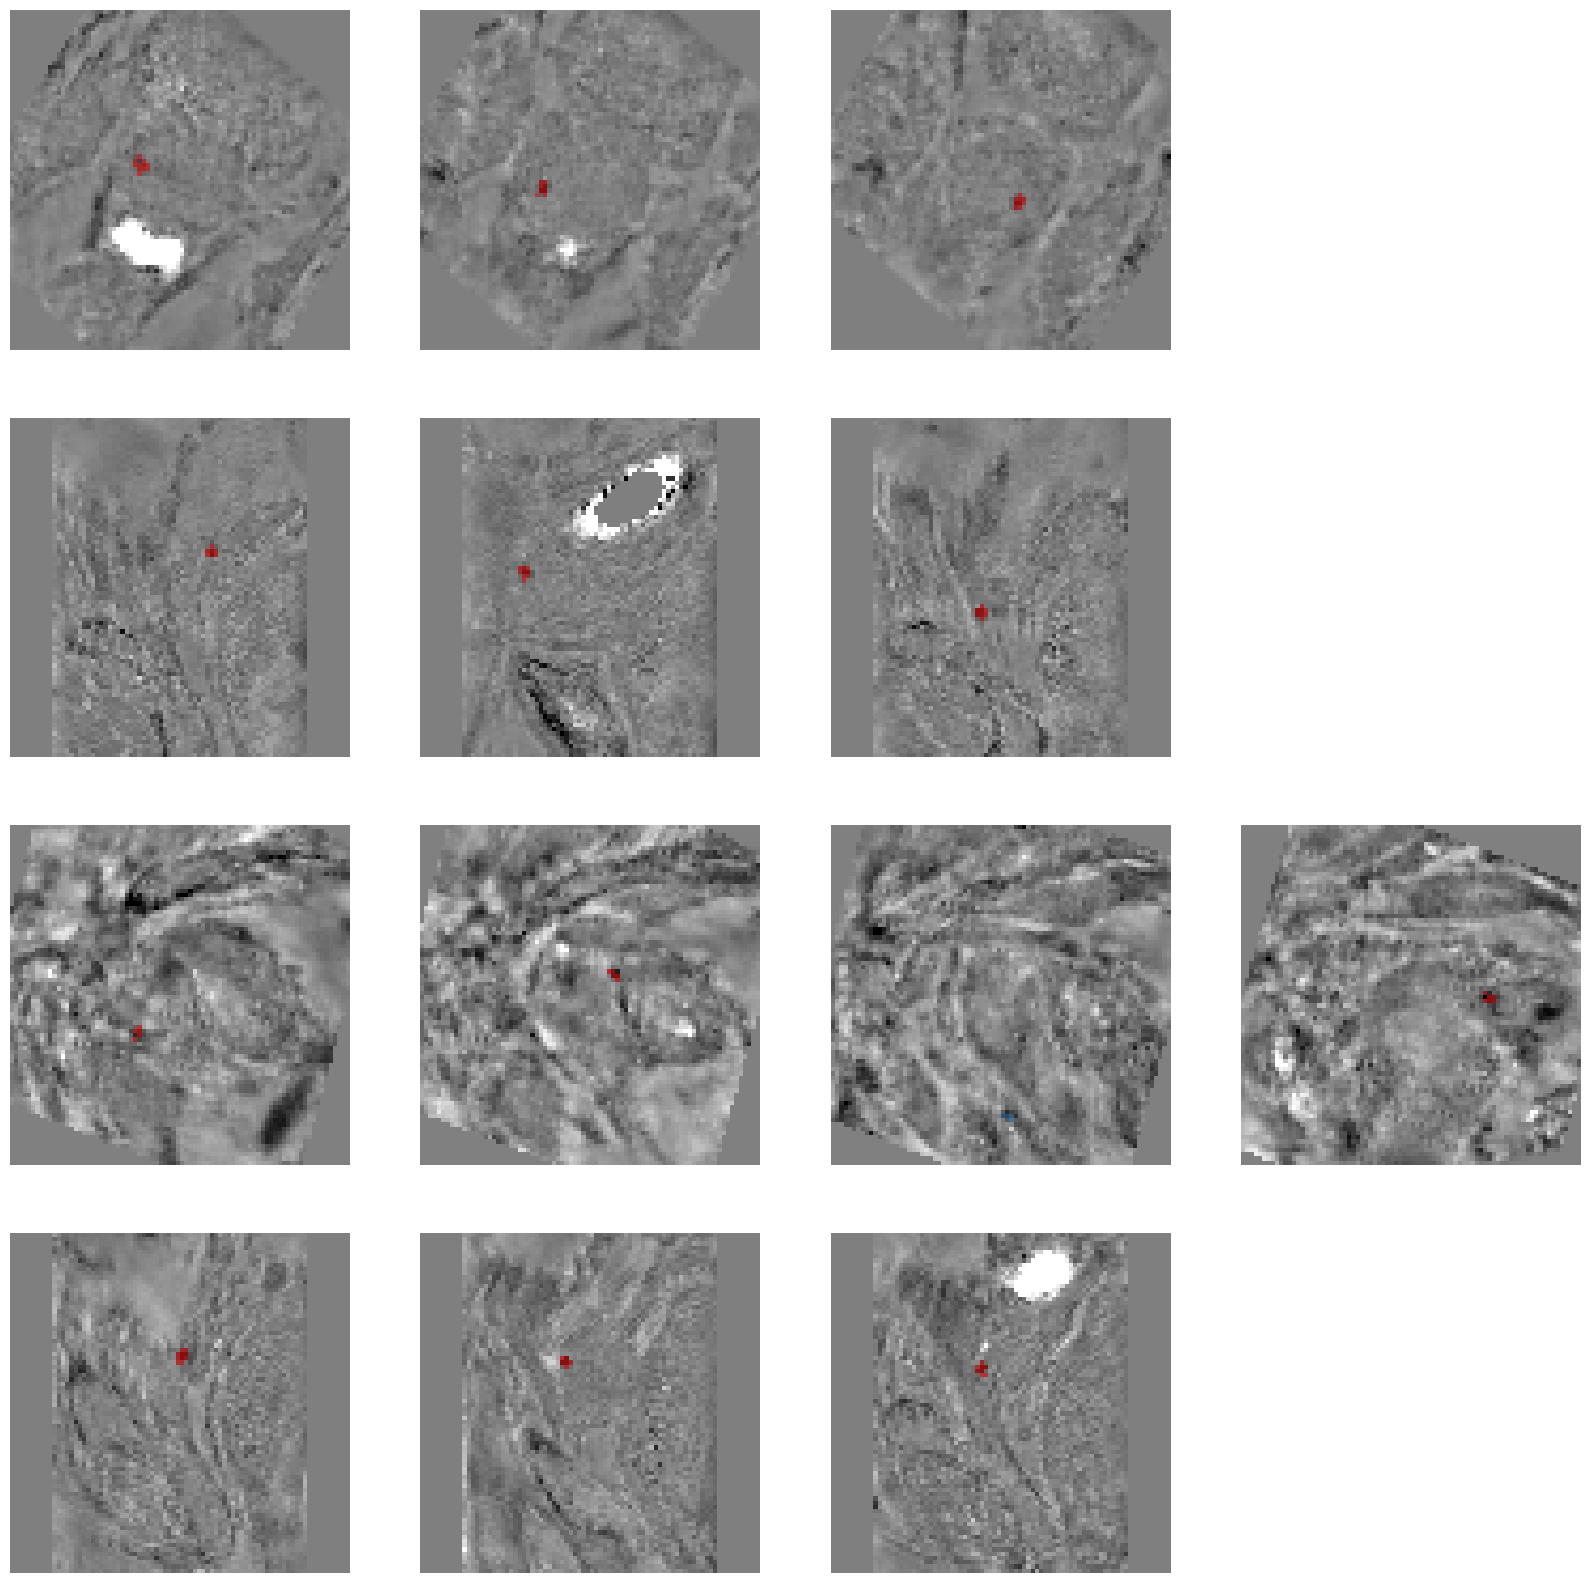

In [9]:
dblock = MedDataBlock(
    blocks=(ImageBlock(cls=MedImage), MedMaskBlock),
    splitter=RandomSplitter(),#seed=42),
    get_x=ColReader('qsm_files'),
    get_y=ColReader('seg_files'),
    item_tfms=[
        PadOrCrop([80, 80, 80]),
        RandomFlip(axes=("LR",)),
        RandomFlip(axes=("AP",)),
        RandomAffine(degrees=(90, 90, 90)),
        ZNormalization(),
    ],
    reorder=requires_resampling,
    resample=suggested_voxelsize
)

dls = DataLoaders.from_dblock(dblock, train_df, bs=4)
print(f"Training examples: {len(dls.train_ds.items)}")
print(f"Validation examples: {len(dls.valid_ds.items)}")
dls.show_batch(anatomical_plane=2)

In [10]:
model = UNet(
    spatial_dims=3,
    in_channels=1,  # qsm
    out_channels=3, # background, marker, calcification
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2
)

In [11]:
class MarkersIdentified(fastai.metrics.Metric):
    def __init__(self):
        super().__init__()
        self.targ_marker_count = 0
        self.pred_marker_count = 0
        self.overlap_count = 0
    
    def reset(self):
        self.targ_marker_count = 0
        self.pred_marker_count = 0
        self.overlap_count = 0
    
    def accumulate(self, learn):
        pred = learn.pred.argmax(dim=1).cpu().numpy()
        targ = learn.y.cpu().numpy()
        for i in range(targ.shape[0]):
            _, pred_nlabels = scipy.ndimage.label(pred[i] == 1)
            _, targ_nlabels = scipy.ndimage.label(targ[i] == 1)
            overlap = np.array(np.logical_and(pred[i] == targ[i], pred[i] == 1), dtype=int)
            _, n_overlaps = scipy.ndimage.label(overlap)
            
            self.pred_marker_count += pred_nlabels
            self.targ_marker_count += targ_nlabels
            self.overlap_count += n_overlaps

    @property
    def value(self):
        return float(self.overlap_count) / max(1., float(self.targ_marker_count))

In [12]:
class SuperfluousMarkers(fastai.metrics.Metric):
    def __init__(self):
        super().__init__()
        self.targ_marker_count = 0
        self.pred_marker_count = 0
        self.overlap_count = 0
    
    def reset(self):
        self.targ_marker_count = 0
        self.pred_marker_count = 0
        self.overlap_count = 0
    
    def accumulate(self, learn):
        pred = learn.pred.argmax(dim=1).cpu().numpy()
        targ = learn.y.cpu().numpy()
        for i in range(targ.shape[0]):
            _, pred_nlabels = scipy.ndimage.label(pred[i] == 1)
            _, targ_nlabels = scipy.ndimage.label(targ[i] == 1)
            overlap = np.array(np.logical_and(pred[i] == targ[i], pred[i] == 1), dtype=int)
            _, n_overlaps = scipy.ndimage.label(overlap)
            
            self.pred_marker_count += pred_nlabels
            self.targ_marker_count += targ_nlabels
            self.overlap_count += n_overlaps

    @property
    def value(self):
        return float(self.pred_marker_count - self.overlap_count) / max(1., float(self.pred_marker_count))

In [13]:
class DiceCELoss2(DiceCELoss):
    def __init__(self, marker_penalty_weight: float = 1.0, **kwargs):
        super().__init__(**kwargs)
        self.marker_penalty_weight = marker_penalty_weight

    def forward(self, input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        original = super().forward(input, target)

        input_np = np.round(input.detach().cpu().numpy() if input.is_cuda else input.detach().numpy())
        target_np = target.detach().cpu().numpy() if target.is_cuda else target.detach().numpy()

        _, n_labels_pred = scipy.ndimage.label(input_np[:,1])
        _, n_labels_targ = scipy.ndimage.label(target_np == 1)

        marker_penalty = abs(n_labels_pred - 3 * input.shape[0])
        normalized_marker_penalty = marker_penalty / input.shape[0]

        total_loss = original + self.marker_penalty_weight * normalized_marker_penalty

        return total_loss

In [14]:
learn = Learner(
    dls,
    model,
    loss_func=DiceCELoss2(
        to_onehot_y=True,
        include_background=True,
        softmax=True
    ),
    opt_func=ranger,
    metrics=[multi_dice_score, MarkersIdentified(), SuperfluousMarkers()]#.to_fp16()
)

In [15]:
lr = 0.003

In [16]:
learn.fit_flat_cos(100, lr)

epoch,train_loss,valid_loss,multi_dice_score,markers_identified,superfluous_markers,time
0,8808.613281,9818.654297,"tensor([0.0004, 0.0006])",2.250000,0.999687,00:04
1,8913.538086,9974.123047,"tensor([0.0004, 0.0006])",2.250000,0.999696,00:04
2,8900.615234,9900.637695,"tensor([0.0004, 0.0006])",2.250000,0.999686,00:04
3,8924.057617,10133.592773,"tensor([0.0004, 0.0006])",2.750000,0.999605,00:04
4,9400.311523,11787.541016,"tensor([0.0003, 0.0007])",3.125000,0.999565,00:04
5,9682.003906,11011.552734,"tensor([0.0003, 0.0007])",2.875000,0.999599,00:04
6,10060.014648,13606.487305,"tensor([0.0004, 0.0007])",2.875000,0.999649,00:04
7,10517.822266,16978.925781,"tensor([0.0004, 0.0007])",3.000000,0.999686,00:04
8,10873.289062,14886.948242,"tensor([0.0004, 0.0007])",2.625000,0.999705,00:04
9,11126.683594,18449.382812,"tensor([0.0004, 0.0006])",2.875000,0.999699,00:05


In [17]:
learn.fit_flat_cos(100, lr)

epoch,train_loss,valid_loss,multi_dice_score,markers_identified,superfluous_markers,time
0,3.434010,3.184081,"tensor([0., 0.])",0.000000,0.000000,00:04
1,3.433543,3.184084,"tensor([0., 0.])",0.000000,0.000000,00:04
2,3.433415,3.183273,"tensor([0., 0.])",0.000000,0.000000,00:04
3,3.433107,3.182491,"tensor([0., 0.])",0.000000,0.000000,00:04
4,3.432769,3.182875,"tensor([0., 0.])",0.000000,0.000000,00:04
5,3.432576,3.182130,"tensor([0., 0.])",0.000000,0.000000,00:05
6,3.432349,3.181425,"tensor([0., 0.])",0.000000,0.000000,00:04
7,3.432088,3.181772,"tensor([0., 0.])",0.000000,0.000000,00:04
8,3.431930,3.181085,"tensor([0., 0.])",0.000000,0.000000,00:04
9,3.431719,3.180433,"tensor([0., 0.])",0.000000,0.000000,00:04


In [18]:
learn.fit_flat_cos(100, lr)

epoch,train_loss,valid_loss,multi_dice_score,markers_identified,superfluous_markers,time
0,3.413319,3.151293,"tensor([0.0000, 0.1435])",0.000000,1.000000,00:04
1,3.411300,3.148953,"tensor([0.0000, 0.2308])",0.000000,1.000000,00:04
2,3.409754,3.150259,"tensor([0.0000, 0.0825])",0.000000,0.000000,00:04
3,3.409286,3.145732,"tensor([0.0127, 0.2231])",0.125000,0.833333,00:04
4,3.408729,3.140913,"tensor([0.0000, 0.3883])",0.000000,1.000000,00:04
5,3.408630,3.140720,"tensor([0.0361, 0.3087])",0.375000,0.666667,00:04
6,3.408360,3.145628,"tensor([0.0127, 0.1058])",0.125000,0.000000,00:05
7,3.407980,3.143106,"tensor([0.0125, 0.1232])",0.125000,0.500000,00:04
8,3.407359,3.142351,"tensor([0.0000, 0.1039])",0.000000,1.000000,00:04
9,3.406375,3.147372,"tensor([0.0127, 0.0206])",0.125000,0.500000,00:04


In [19]:
learn.fit_flat_cos(100, lr)

epoch,train_loss,valid_loss,multi_dice_score,markers_identified,superfluous_markers,time
0,3.215157,2.938440,"tensor([0.7070, 0.0515])",0.875000,0.125000,00:04
1,3.196223,2.945282,"tensor([0.6565, 0.0796])",0.750000,0.000000,00:04
2,3.189577,2.930857,"tensor([0.7393, 0.0521])",0.875000,0.222222,00:04
3,3.186943,2.927661,"tensor([0.7373, 0.0619])",0.875000,0.222222,00:04
4,3.189917,2.933367,"tensor([0.7316, 0.0788])",0.875000,0.125000,00:04
5,3.183945,2.932206,"tensor([0.7194, 0.0697])",0.875000,0.125000,00:04
6,3.186066,2.930431,"tensor([0.7082, 0.0693])",0.750000,0.000000,00:05
7,3.184126,2.930364,"tensor([0.7198, 0.0780])",0.750000,0.142857,00:04
8,3.182276,2.930746,"tensor([0.7107, 0.0707])",0.750000,0.142857,00:04
9,3.181552,2.944444,"tensor([0.6780, 0.0430])",0.750000,0.142857,00:04


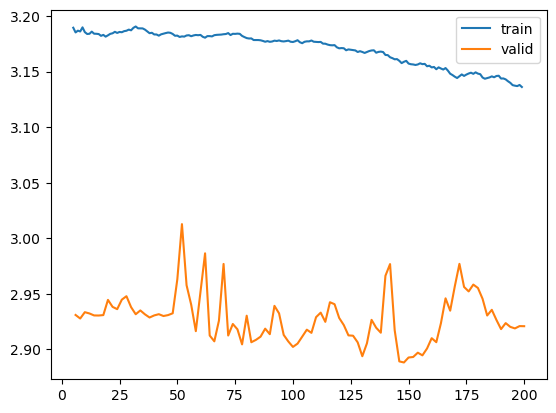

In [20]:
learn.recorder.plot_loss()

In [21]:
learn.save('prostate-model')

Path('models/prostate-model.pth')

In [22]:
#learn.load('models/prostate-model.pth')

In [23]:
@typedispatch
def show_results(x:MedImage, y:MedMask, samples, outs, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    outs = torch.stack([outs[i][0] for i in range(len(outs))], dim=0)
    #samples_x = torch.stack([samples[i][0][0] for i in range(len(samples))], dim=0).unsqueeze(1)
    #samples_y = torch.stack([samples[i][1] for i in range(len(samples))], dim=0)
    #show_images(x, y)
    #show_images(samples_x, samples_y)
    show_images(x, y)
    show_images(x, outs)

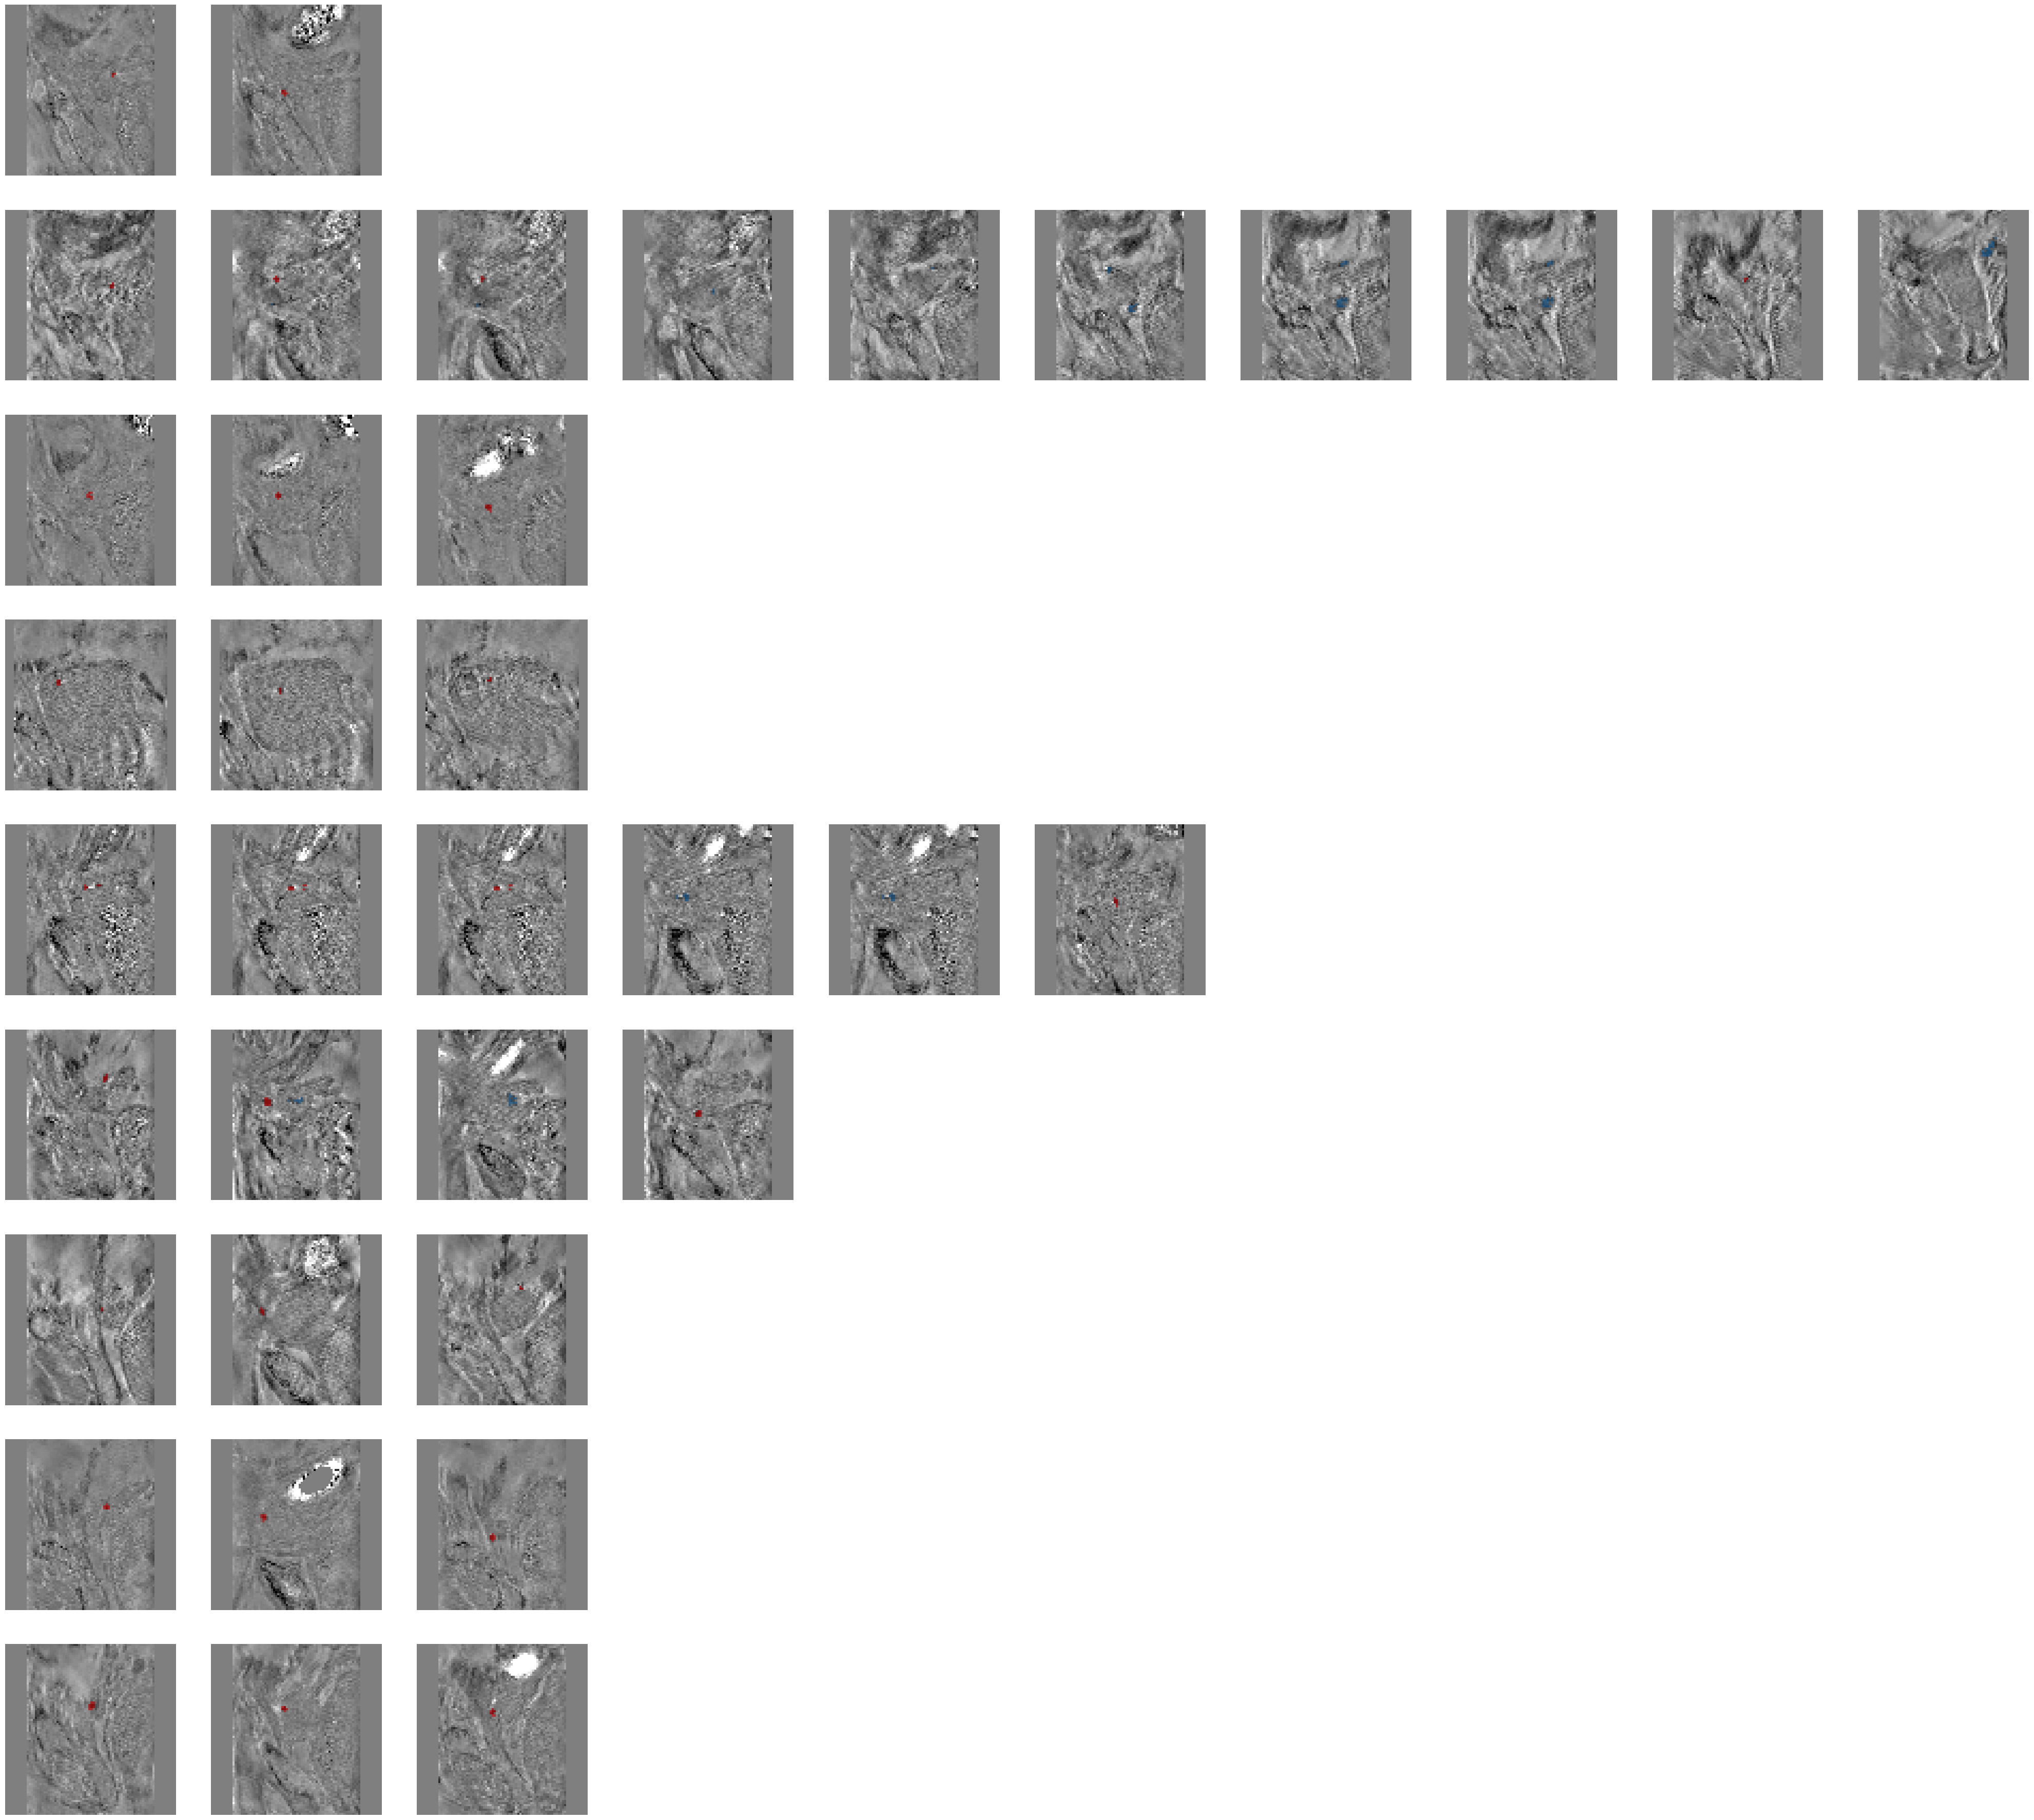

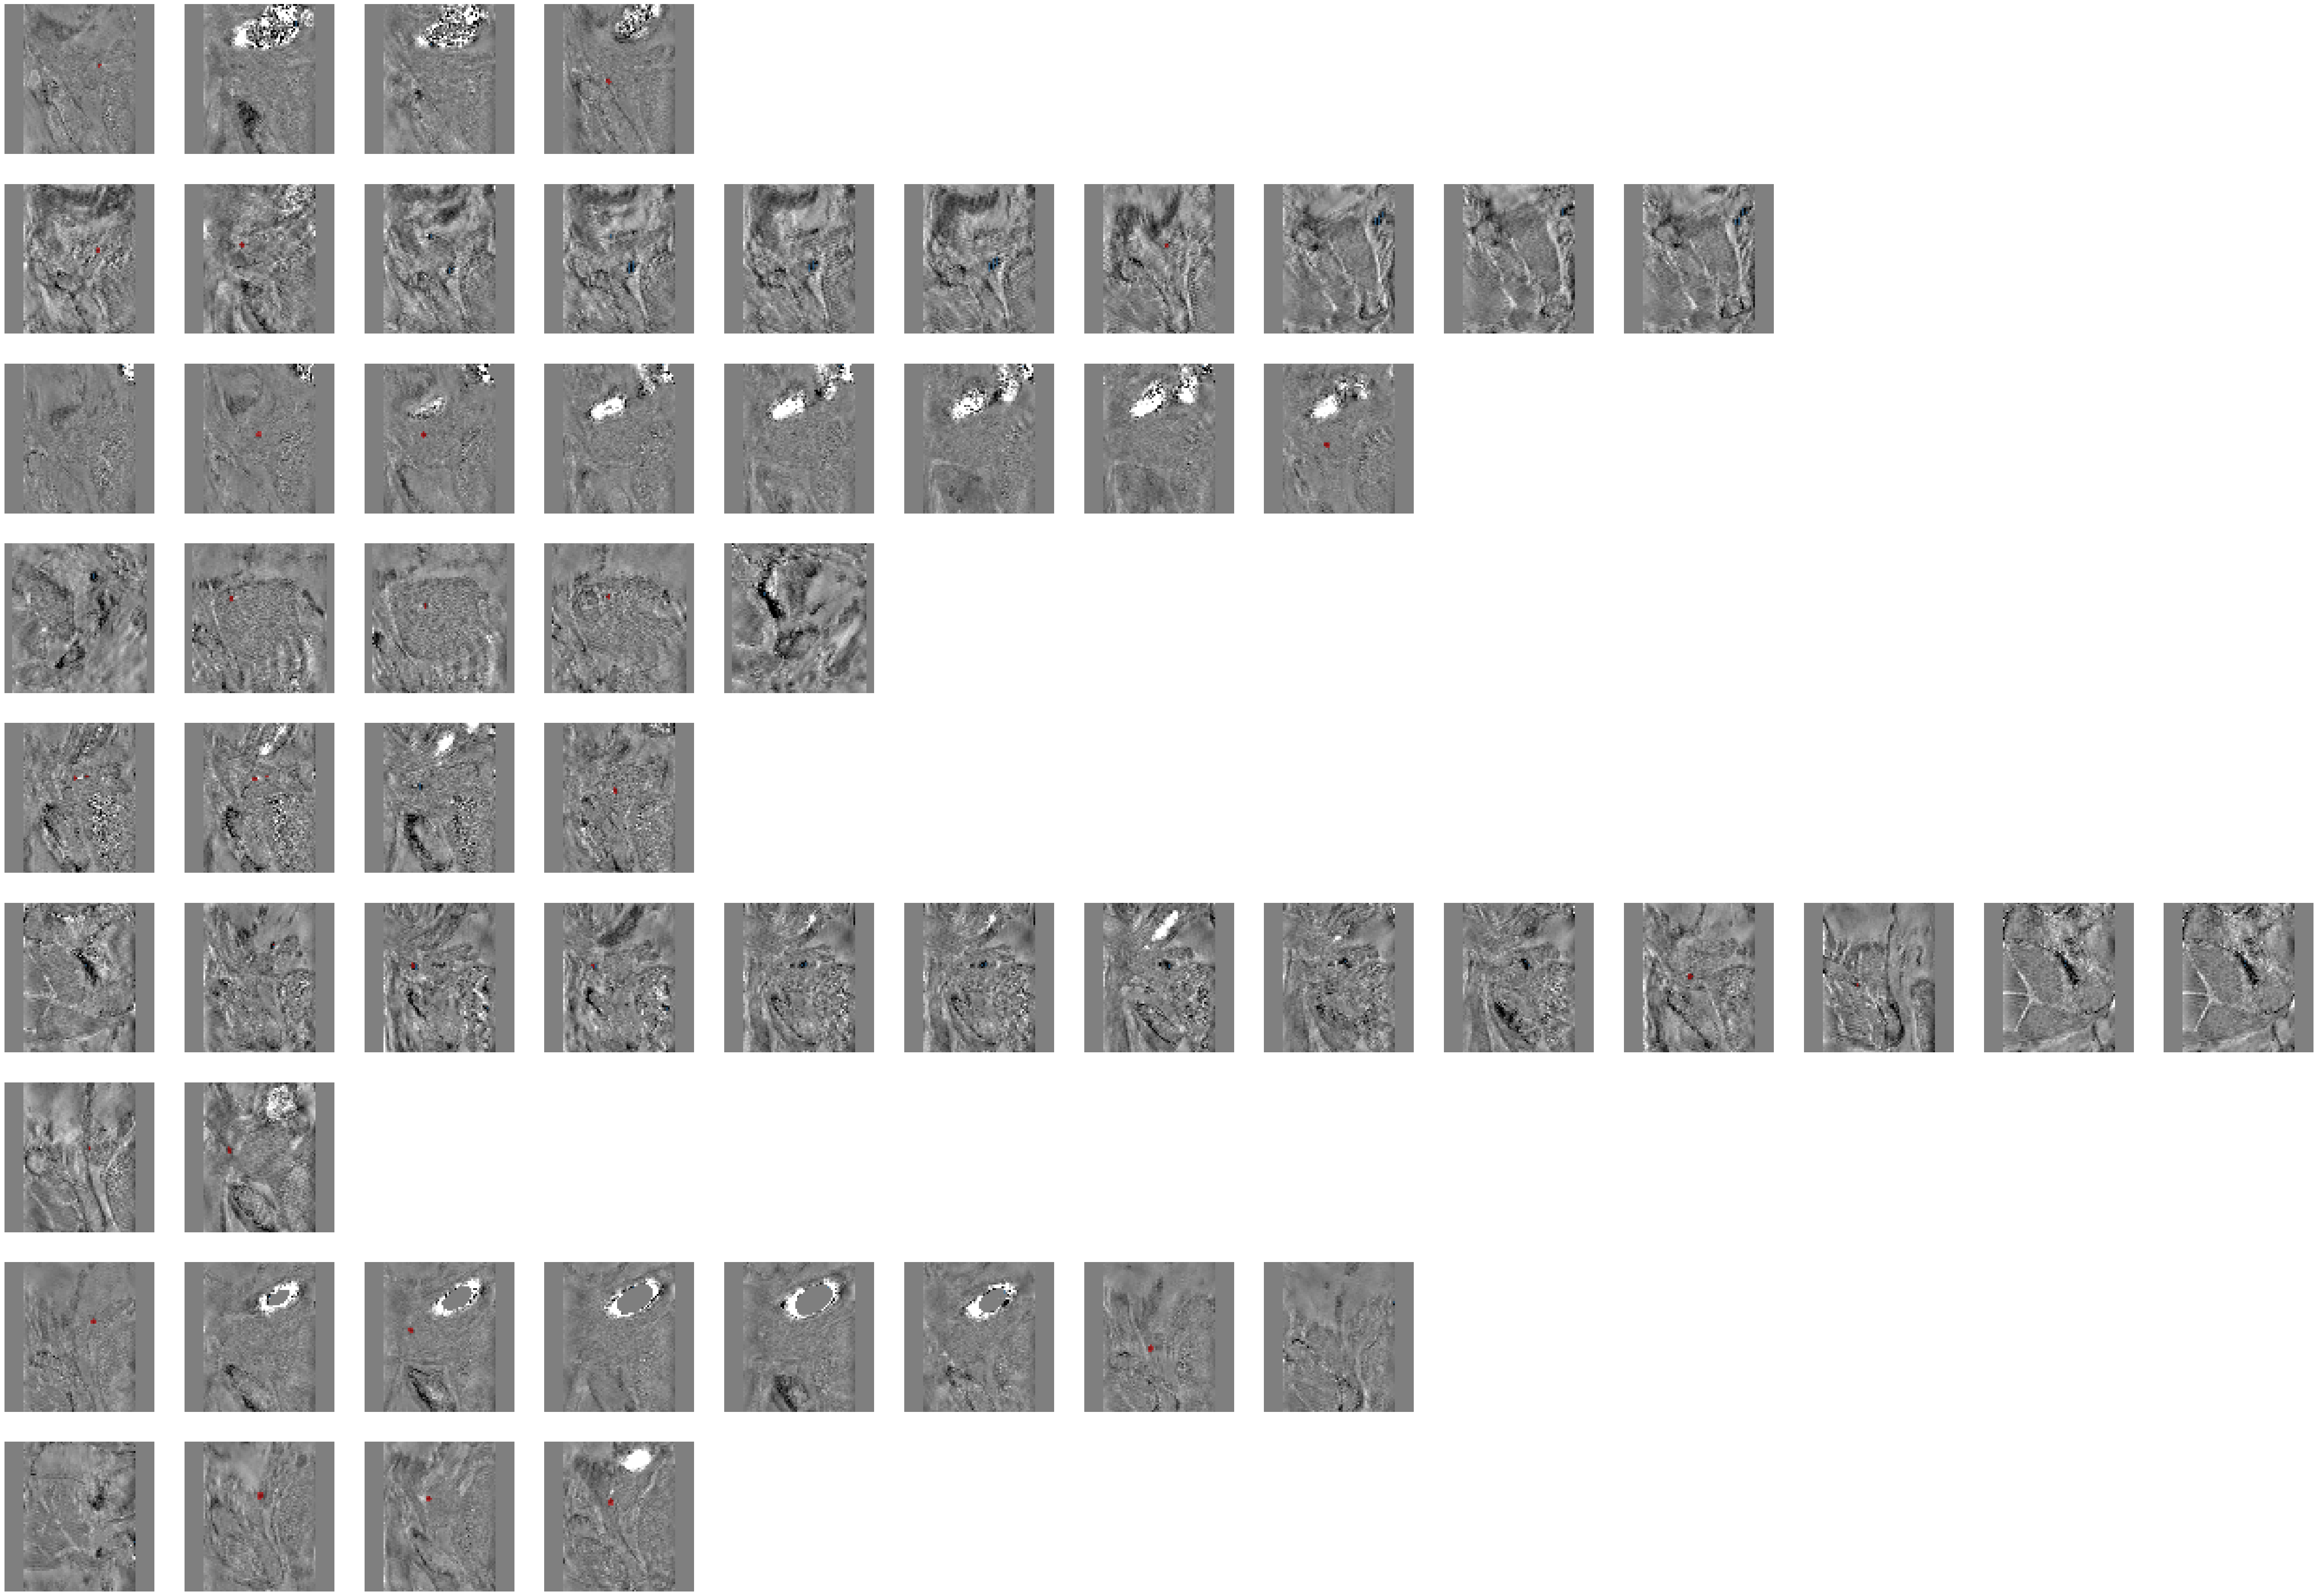

Dice score: tensor([0.9012, 0.4313]); Markers identified: 0.8620689655172413; Superfluous markers: 0.038461538461538464


In [24]:
dblock_train = MedDataBlock(
    blocks=(ImageBlock(cls=MedImage), MedMaskBlock),
    #splitter=RandomSplitter(),
    get_x=ColReader('qsm_files'),
    get_y=ColReader('seg_files'),
    item_tfms=[
        PadOrCrop([80, 80, 80]),
        #RandomFlip(axes=("LR",)),
        #RandomFlip(axes=("AP",)),
        #RandomAffine(degrees=(90, 90, 90)),
        ZNormalization(),
    ],
    reorder=requires_resampling,
    resample=suggested_voxelsize
)

dls_train = DataLoaders.from_dblock(dblock_train, train_df, bs=9)

learn.show_results(anatomical_plane=0, dl=dls_train, shuffle=True)
loss, *metrics = learn.validate(dl=dls_train[0])
print(f"Dice score: {metrics[0]}; Markers identified: {metrics[1]}; Superfluous markers: {metrics[2]}")

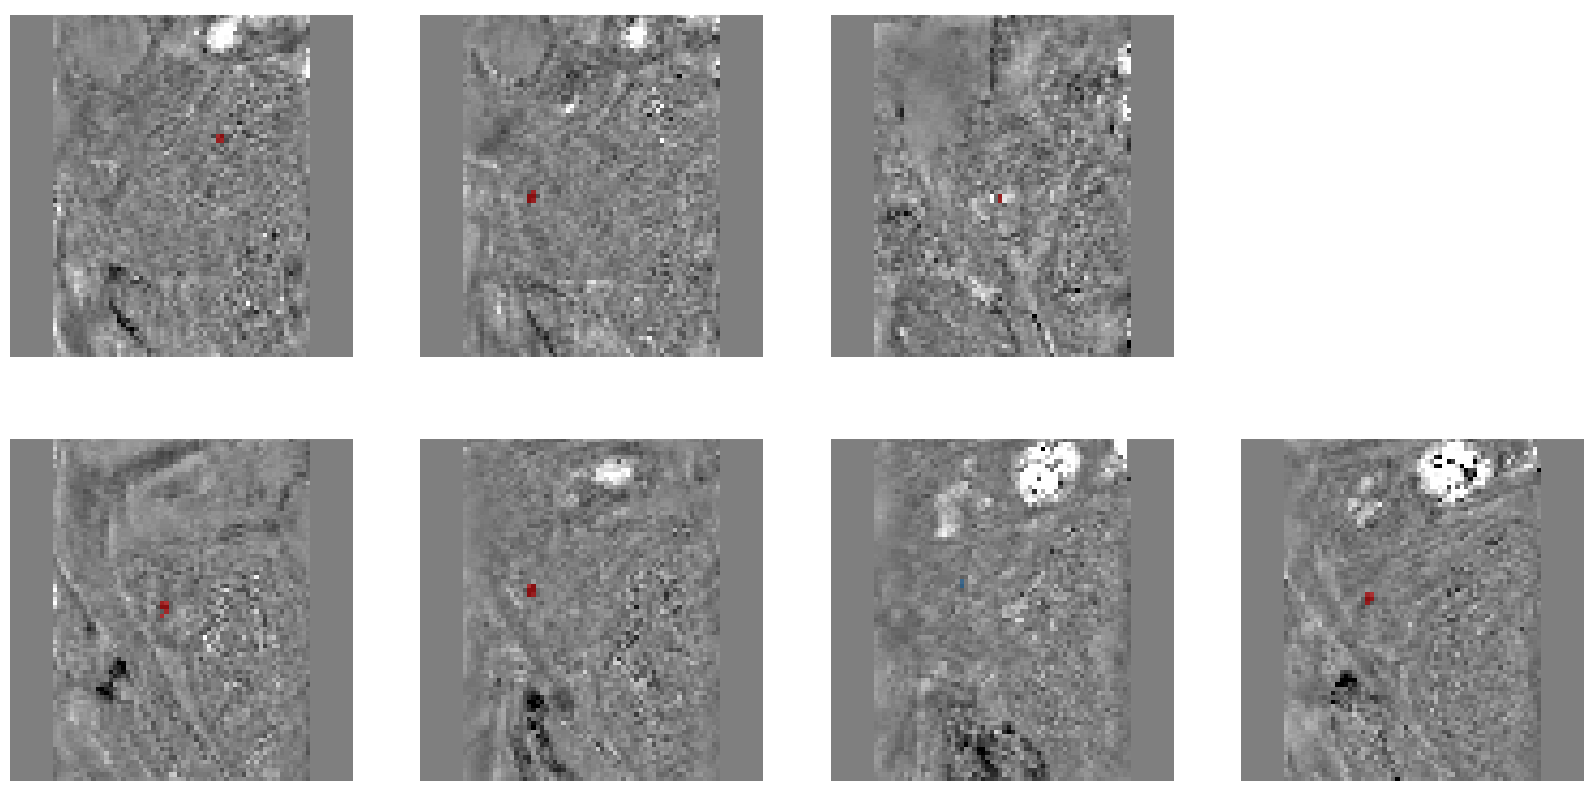

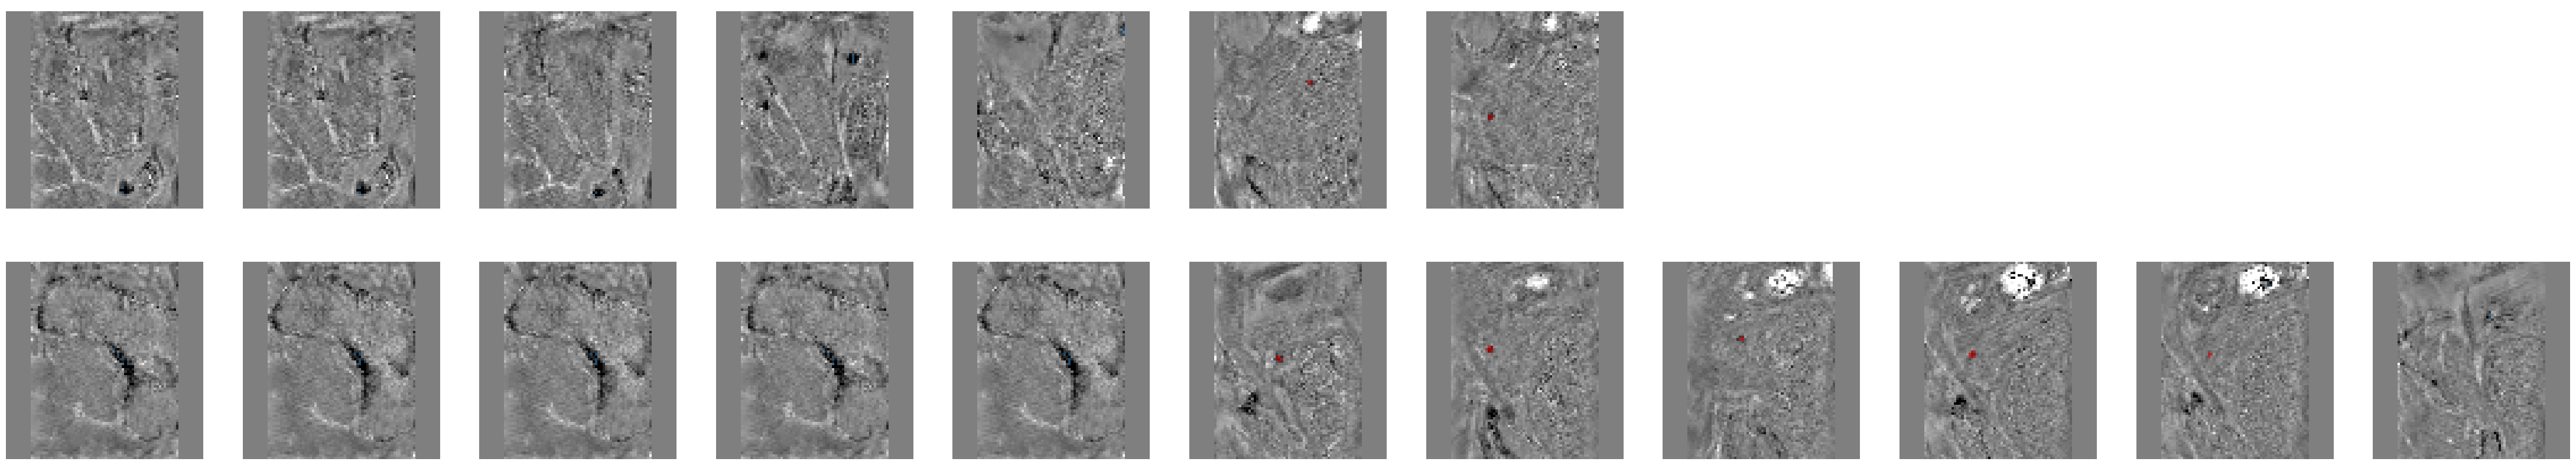

Dice score: tensor([0.6701, 0.0000]); Markers identified: 0.8333333333333334; Superfluous markers: 0.16666666666666666


In [25]:
dblock_test = MedDataBlock(
    blocks=(ImageBlock(cls=MedImage), MedMaskBlock),
    splitter=RandomSplitter(),
    get_x=ColReader('qsm_files'),
    get_y=ColReader('seg_files'),
    item_tfms=[
        PadOrCrop([80, 80, 80]),
        #RandomFlip(axes=("LR",)),
        #RandomFlip(axes=("AP",)),
        #RandomAffine(degrees=(90, 90, 90)),
        ZNormalization(),
    ],
    reorder=requires_resampling,
    resample=suggested_voxelsize
)

dls_test = DataLoaders.from_dblock(dblock_test, test_df, bs=len(test_df))

learn.show_results(anatomical_plane=0, dl=dls_test, shuffle=True)
loss, *metrics = learn.validate(dl=dls_test[0])
print(f"Dice score: {metrics[0]}; Markers identified: {metrics[1]}; Superfluous markers: {metrics[2]}")